In [4]:
from google.colab import files
uploaded = files.upload()

Saving top_women_chess_players_aug_2020.csv to top_women_chess_players_aug_2020 (1).csv


In [5]:
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf

data = pd.read_csv ("top_women_chess_players_aug_2020.csv")

print(data.head())
print(data.isna().sum())

   Fide id                     Name Federation Gender  Year_of_birth Title  \
0   700070            Polgar, Judit        HUN      F         1976.0    GM   
1  8602980               Hou, Yifan        CHN      F         1994.0    GM   
2  5008123            Koneru, Humpy        IND      F         1987.0    GM   
3  4147103  Goryachkina, Aleksandra        RUS      F         1998.0    GM   
4   700088            Polgar, Susan        HUN      F         1969.0    GM   

   Standard_Rating  Rapid_rating  Blitz_rating Inactive_flag  
0             2675        2646.0        2736.0            wi  
1             2658        2621.0        2601.0           NaN  
2             2586        2483.0        2483.0           NaN  
3             2582        2502.0        2441.0           NaN  
4             2577           NaN           NaN            wi  
Fide id               0
Name                  0
Federation            0
Gender                0
Year_of_birth       292
Title              5435
Standard_

In [7]:
#Step 1: Drop less useful columns
data = data.drop(['Fide id','Name','Gender'],axis=1)

#Step 2: Drop entries without YOB
data = data.dropna(subset=['Year_of_birth'])

#Step 3: Replace label values
data['Inactive_flag'] = data['Inactive_flag'].replace(to_replace=np.nan,value='active')
data['Inactive_flag'] = data['Inactive_flag'].replace(to_replace='wi',value='inactive')

#Step 4: Fill missing values in Title column
data['Title'] = data['Title'].replace(to_replace=np.nan,value='Other')

#Step 5: Numerical encoding for Federation
from sklearn.preprocessing import LabelEncoder

l1 = LabelEncoder()
l1.fit(data['Federation'])
data['Federation'] = l1.transform(data['Federation'])

#%%
#Step 6: One hot encode the rest of categorical columns (Title and Inactive_flag)
data = pd.get_dummies(data)

#%%
#Step 7: Fill up other missing numerical values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='constant',fill_value=0)

data_np = imputer.fit_transform(data)
data2 = pd.DataFrame(data_np)

#Step 8: Split features and labels
data_features = data2.copy()
data_labels = pd.concat([data_features.pop(x) for x in [15,16]],axis=1)

#%%
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
SEED=12345
x_train, x_test, y_train, y_test = train_test_split(data_features,data_labels,train_size=0.2,random_state=SEED)

standardizer = preprocessing.StandardScaler()
standardizer.fit(x_train)
x_train = standardizer.transform(x_train)
x_test = standardizer.transform(x_test)

#Data preparation complete

In [8]:
#Model creation
nClass = np.array(y_test).shape[1]
inputs = tf.keras.Input(shape=(x_train.shape[-1],))
dense = tf.keras.layers.Dense(64,activation='relu')
x = dense(inputs)
dense = tf.keras.layers.Dense(32,activation='relu')
x = dense(x)
dense = tf.keras.layers.Dense(16,activation='relu')
x = dense(x)
outputs = tf.keras.layers.Dense(nClass,activation='softmax')(x)

model = tf.keras.Model(inputs=inputs,outputs=outputs,name='wc_model')
model.summary()

Model: "wc_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense (Dense)               (None, 64)                1024      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,666
Trainable params: 3,666
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=16,epochs=25)

Epoch 1/25
104/104 [==============================] - 3s 22ms/step - loss: 0.5545 - accuracy: 0.7415 - val_loss: 0.4669 - val_accuracy: 0.7826
Epoch 2/25
104/104 [==============================] - 1s 11ms/step - loss: 0.4600 - accuracy: 0.7815 - val_loss: 0.4570 - val_accuracy: 0.7841
Epoch 3/25
104/104 [==============================] - 1s 8ms/step - loss: 0.4479 - accuracy: 0.7942 - val_loss: 0.4567 - val_accuracy: 0.7842
Epoch 4/25
104/104 [==============================] - 1s 8ms/step - loss: 0.4416 - accuracy: 0.7912 - val_loss: 0.4505 - val_accuracy: 0.7891
Epoch 5/25
104/104 [==============================] - 1s 7ms/step - loss: 0.4317 - accuracy: 0.8051 - val_loss: 0.4444 - val_accuracy: 0.7936
Epoch 6/25
104/104 [==============================] - 1s 8ms/step - loss: 0.4222 - accuracy: 0.8027 - val_loss: 0.4411 - val_accuracy: 0.7926
Epoch 7/25
104/104 [==============================] - 1s 8ms/step - loss: 0.4197 - accuracy: 0.8099 - val_loss: 0.4394 - val_accuracy: 0.7942
Epoc

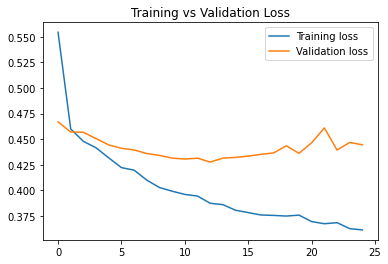

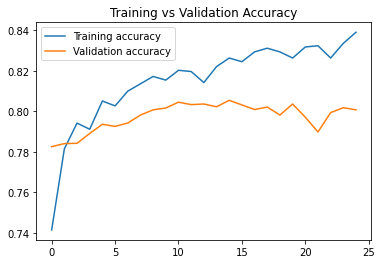

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
val_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = history.epoch

plt.plot(epochs,training_loss,label='Training loss',)
plt.plot(epochs,val_loss,label='Validation loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.figure()

plt.plot(epochs,training_accuracy,label='Training accuracy')
plt.plot(epochs,val_accuracy,label='Validation accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.figure()


plt.show()